In [58]:
import os
import sys

from pathlib import Path


# si aggiunge al path la cartella utils per avere visibilità del module
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [59]:
import timm
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import utils.mining as mining
import utils.datasets as build
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from skimage import io
from sklearn.metrics import confusion_matrix

In [60]:
# classe per caricare il modello di rete neurale direttamente dalle repository online
class ApnModel(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size=512):
    super(ApnModel, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [61]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, fake_data_dir, real_data_dir, device):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr, desc="creating encodings..."):
      if "real" in str(i):
        dir_folder = real_data_dir
      else: 
        dir_folder = fake_data_dir

      a = io.imread(os.path.join(dir_folder, i))
      a = np.expand_dims(a, 0)
      a = torch.from_numpy(a.astype(np.int32)) / 255.0
      a = a.to(device)
      
      a_enc = model(a.unsqueeze(0))
      encodings.append(a_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    anc_img_names_df = pd.DataFrame(anc_img_names_arr, columns=['Anchor'])
    df_enc = pd.concat([anc_img_names_df, encodings], axis=1)

    return df_enc

In [62]:
def get_image_embeddings(img, model, device):
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(device)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [63]:
def search_in_database(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = mining.array_distance(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [64]:
# serve per ricaricare il codice modificato
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# configurazione
batch_size=32
lr=0.001
epochs=30
device="cuda"
fake_dataset = "latent_diffusion"
real_dataset = "coco"

In [66]:
# directory da dove vengono prelevate le immagini del dataset di train
fake_data_dir = os.path.join("..", "temp", "taming_transformer+coco", "train", "taming_transformer")
real_data_dir = os.path.join("..", "temp", "taming_transformer+coco", "train", "coco")

In [67]:
# si ottiene il dataset di train che serve per creare gli encodings
df_out_path = os.path.join("..", "datasets", "fourier_out.csv")
df_out = pd.read_csv(df_out_path)

In [68]:
model = ApnModel()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(device);

In [69]:
# per ricaricare il modello già allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati 
if not os.path.isfile("database.csv"):
    df_enc = get_encoding_csv(model, df_out["Anchor"], fake_data_dir, real_data_dir)
    df_enc.to_csv("database.csv", index=False)

In [70]:
df_enc = pd.read_csv('database.csv')

In [71]:
# si crea un dataset di test e lo si converte in fourier
artifact_path = os.path.join("..", "..", "artifact")
fake_dataset_path = os.path.join(artifact_path, fake_dataset, "metadata.csv")
real_dataset_path = os.path.join(artifact_path, real_dataset, "metadata.csv")

temp_path = os.path.join("..", "temp")

# se non c'è la cartella temp la si crea
if not os.path.isdir(temp_path): 
    os.mkdir(temp_path)

path = os.path.join("..", "temp", fake_dataset + "+" + real_dataset)

# se non c'è la cartella della combinazione dei dataset scelti la si crea
if not os.path.isdir(path): 
    os.mkdir(path)
    os.mkdir(os.path.join(path, "test"))
    os.mkdir(os.path.join(path, "test", real_dataset))
    os.mkdir(os.path.join(path, "test", fake_dataset))

test_df_path = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "test", "test_list.csv")

# creo il dataset di test
build.test(fake_dataset_path, real_dataset_path, df_out, test_df_path)

building (fake column) test dataframe...:   5%|▍         | 999/20000 [00:00<00:00, 997170.32it/s]


In [72]:
test_df = pd.read_csv(test_df_path)

In [73]:
fake_dataset_path = os.path.join(artifact_path, fake_dataset)
real_dataset_path = os.path.join(artifact_path, real_dataset)
fourier_test_df_path = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "test", "fourier_test_list.csv")

# si convertono nello spettro di fourier le immagini del dataset di test
build.convert_test(fake_dataset_path, real_dataset_path, test_df, fourier_test_df_path)


converting rgb images (real) to fourier spectrum...: 100%|██████████| 2000/2000 [01:58<00:00, 16.91it/s]
converting rgb images (fake) to fourier spectrum...: 100%|██████████| 1000/1000 [00:42<00:00, 23.75it/s]


In [74]:
fourier_test_df = pd.read_csv(fourier_test_df_path)

In [75]:
y_true = []
y_pred = []

temp_df = fourier_test_df
temp_df.head()
temp_df.shape

(2000, 2)

In [76]:
# directory da dove vengono prelevate le immagini del dataset di test
fake_data_dir = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "test", fake_dataset)
real_data_dir = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "test", real_dataset)

In [77]:
# testo i fake
current_test = "fake"
database = df_enc

fake_images = temp_df[current_test].dropna()
print(len(fake_images))

# prendo i primi 500 Fake
for i in tqdm(fake_images, desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, i)
    img_name = path

    img = io.imread(img_name)
    img_enc = get_image_embeddings(img, model, device)
    closest_label = search_in_database(img_enc, database)
    
    if "real" in str(closest_label):
        y_pred.append("real")
    else:
        y_pred.append("fake")

1000


testing on fake images...: 100%|██████████| 1000/1000 [14:40<00:00,  1.14it/s]


In [78]:
# testo i real
current_test = "real"
database = df_enc

real_images = temp_df[current_test]
print(len(real_images))

for i in tqdm(real_images, desc="testing on real images..."):
    path = os.path.join(real_data_dir, i)
    img_name = path

    img = io.imread(img_name)
    img_enc = get_image_embeddings(img, model, device)
    closest_label = search_in_database(img_enc, database)

    if "real" in str(closest_label):
        y_pred.append("real")
    else:
        y_pred.append("fake")

2000


testing on real images...: 100%|██████████| 2000/2000 [28:56<00:00,  1.15it/s]


In [79]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * len(temp_df["fake"].dropna()))
temp = np.array(["real"] * len(temp_df["real"]))
y_true = np.concatenate([y_true, temp])

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

[[1735  265]
 [ 381  619]]


In [80]:
tn, fp, fn, tp = cm.ravel()

# metriche
accuracy = round((tp + tn) / (tp + tn + fp + fn), 4) * 100
precision = round((tp) / (tp + fp), 4) * 100
recall = round((tp) / (tp + fn), 4) * 100
specificity = round((tn) / (tn + fp) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 78.47, 'Precision': 70.02000000000001, 'Recall': 61.9, 'Specificity': 86.75, 'F1 Score': 65.7101}


In [98]:
# si carica il df di test per creare quello di one-shot
test_df = pd.read_csv(test_df_path)

In [99]:
path = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "oneshot")

# se non c'è la cartella della combinazione dei dataset scelti la si crea
if not os.path.isdir(path): 
    os.mkdir(path)
    os.mkdir(os.path.join(path, real_dataset))
    os.mkdir(os.path.join(path, fake_dataset))

In [130]:
# size è il numero di immagini da aggiungere al df degli encodings per fare one-shot
size = 1000
oneshot_df_path = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "oneshot", "oneshot.csv")

fake_dataset_path = os.path.join("..", "..", "artifact", fake_dataset, "metadata.csv")

# si crea il dataset per il one-shot (n.b. df_test deve essere quello non convertito in fourier)
build.oneshot(fake_dataset_path, test_df, size, oneshot_df_path)

building one-shot learning dataframe...:   5%|▌         | 1052/20000 [00:00<00:00, 1051324.23it/s]


In [131]:
oneshot_df = pd.read_csv(oneshot_df_path)

In [132]:
fourier_oneshot_df_path = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "oneshot", "fourier_oneshot.csv")

fake_dataset_path = os.path.join("..", "..", "artifact", fake_dataset)

# si converte il dataframe di oneshot in fourier
build.convert_oneshot(fake_dataset_path, oneshot_df, fourier_oneshot_df_path)

converting rgb images (fake) to fourier spectrum...: 100%|██████████| 1000/1000 [00:21<00:00, 46.73it/s]


In [133]:
fourier_oneshot_df = pd.read_csv(fourier_oneshot_df_path)

In [134]:
# per ricaricare il modello
model.load_state_dict(torch.load("best_model.pt"))

fake_data_dir = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "oneshot", fake_dataset)
real_data_dir = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "oneshot", real_dataset)

# si creano gli embeddings delle immagini da aggiungere per il one-shot learning
df_enc_oneshot = get_encoding_csv(model, fourier_oneshot_df["Anchor"], fake_data_dir, real_data_dir, device)
df_enc_oneshot.to_csv("database_oneshot.csv", index=False)

creating encodings...: 100%|██████████| 1000/1000 [00:24<00:00, 41.28it/s]


In [135]:
df_enc = pd.read_csv("database.csv")
df_enc_oneshot = pd.read_csv("database_oneshot.csv")

# concateno i due dataframe di encoding 
df_enc = pd.concat([df_enc, df_enc_oneshot], axis=0).reset_index(drop=True)
print(len(df_enc))

51000


In [136]:
fake_data_dir = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "test", fake_dataset)
real_data_dir = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "test", real_dataset)

In [137]:
fourier_test_df_path = os.path.join("..", "temp", fake_dataset + "+" + real_dataset, "test", "fourier_test_list.csv")
# si rifanno i test per vedere quanto siano migliorate le metriche
fourier_test_df = pd.read_csv(fourier_test_df_path)

In [138]:
y_true = []
y_pred = []

temp_df = fourier_test_df
temp_df.head()
temp_df.shape

(2000, 2)

In [139]:
# testo i fake
current_test = "fake"
database = df_enc

fake_images = temp_df[current_test].dropna()
print(len(fake_images))

# prendo i primi 500 Fake
for i in tqdm(fake_images, desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, i)
    img_name = path

    img = io.imread(img_name)
    img_enc = get_image_embeddings(img, model, device)
    closest_label = search_in_database(img_enc, database)
    
    if "real" in str(closest_label):
        y_pred.append("real")
    else:
        y_pred.append("fake")

1000


testing on fake images...: 100%|██████████| 1000/1000 [15:28<00:00,  1.08it/s]


In [140]:
# testo i real
current_test = "real"
database = df_enc

real_images = temp_df[current_test]
print(len(real_images))

for i in tqdm(real_images, desc="testing on real images..."):
    path = os.path.join(real_data_dir, i)
    img_name = path

    img = io.imread(img_name)
    img_enc = get_image_embeddings(img, model, device)
    closest_label = search_in_database(img_enc, database)

    if "real" in str(closest_label):
        y_pred.append("real")
    else:
        y_pred.append("fake")

2000


testing on real images...: 100%|██████████| 2000/2000 [30:38<00:00,  1.09it/s]


In [141]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * len(temp_df["fake"].dropna()))
temp = np.array(["real"] * len(temp_df["real"]))
y_true = np.concatenate([y_true, temp])

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

[[1722  278]
 [ 371  629]]


In [142]:
tn, fp, fn, tp = cm.ravel()

# metriche
accuracy_oneshot = round((tp + tn) / (tp + tn + fp + fn), 4) * 100
precision_oneshot = round((tp) / (tp + fp), 4) * 100
recall_oneshot = round((tp) / (tp + fn), 4) * 100
specificity_oneshot = round((tn) / (tn + fp) * 100, 4)
f1_score_oneshot = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy_oneshot, "Precision":precision_oneshot, "Recall":recall_oneshot, "Specificity":specificity_oneshot, "F1 Score":f1_score_oneshot})

{'Accuracy': 78.36999999999999, 'Precision': 69.35, 'Recall': 62.9, 'Specificity': 86.1, 'F1 Score': 65.7101}


In [143]:
# si salvano i risultati in un file .csv
data = {
    "Metrica": ["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"],
    "Prima": [accuracy, precision, recall, specificity, f1_score],
    "Dopo": [accuracy_oneshot, precision_oneshot, recall_oneshot, specificity_oneshot, f1_score_oneshot]
}

df_results = pd.DataFrame(data)

# si differenziano i risultati in base al tipo di dataset usato
path = os.path.join("..", "results", "oneshot", "siamese_" + fake_dataset + "_results.csv")

df_results.to_csv(path, index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

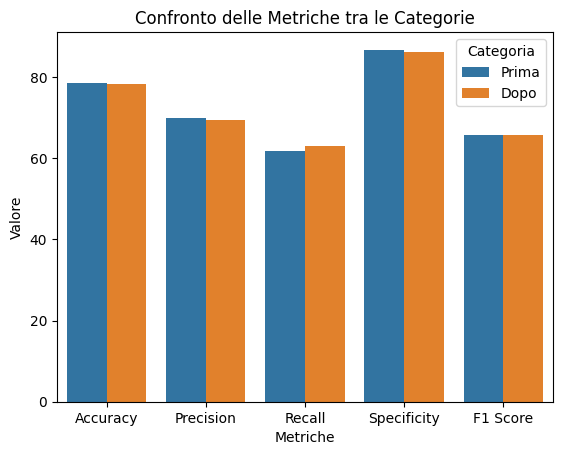

In [144]:
df_melted = df_results.melt(id_vars="Metrica", var_name="Differenza", value_name="Valore")

sns.barplot(data=df_melted, x="Metrica", y="Valore", hue="Differenza")

plt.title('Confronto delle Metriche tra le Categorie')
plt.xlabel('Metriche')
plt.ylabel('Valore')
plt.legend(title='Categoria')

plt.show